# How covid-19 narratives are related to its propagation on social media?

**Author**: Muheng Yan


# A few Important Features and their Description

***Connectivity probabilities***: ratio of neighbors of a node belongs to the specific color. E.g. 0.1 of "green" in connectivity probability refers 10% of the node's neighbor are green nodes.

***Homophily***: ratio of neighbors of a node belongs to the "SAME" color. E.g. 0.1 of homophily for a red node indicates that 10% of its neighbors are red.

***LIWC features***: proportion of actants in a node appeared with the spicific LIWC features in a same sentence. E.g. node "man" consists of two actants of "man" appeared once with "negate", then the "negate" score for the node is 0.5.

***Popularity***: the average popularity scores ((#rt + #favorate)/(#followers + epsilon) per article) of articles  where any actants in a node appeared in.

***Lifespan***: the average lifespan of articles (last post date - first post date in hours) where any actants in a node appeared in.

***Halflife***: the average "hours an article get 50% shares" where any actants in a node appeared in.

***Velocity Ratio***: the average "halflife / lifespan" of areticles where any actants in a node appeared in.


------------------------------------------------------------------------------------------------------------------------------

# Further RQs from previous discoveries

Following the discussions in the last update, further questions are organized as two tracks:

## 1. What does the rumor cliques tell? 

**highlighted summary**: 

The relatedness to the rumor "bioweapon" significantly differ on color/popularity. Specifically, red + high-popularity nodes are having much higher relatedness to this rumor.


## 2. In predciting popularity/velocity/color coding, what are the significance of the features (in general linear model)?

**highlighted summary**: 

All of connectivity features, LIWC features, and the "bioweapon" rumor provides fair predictive power on color/popularity/velocity. Details:

note: "suspicious" below refers orange/red, "slower/faster" propagation refers "larger/smaller" velocity ratio.

**connect to orange/red nodes**: positive siginificance predicting suspicious nodes. moreover, connecting to orange nodes tends to make a node less popular, connecting to red nodes tends to make a node propagate faster

**positive emotion** -> less suspicious, less popular, shorter halflife, slower propagation

**anxiety** -> less suspicious

**sadness** -> less suspicious

**anger** -> shorter halflife, propagate faster

**certain and religion** -> more suspicious

**social** -> less suspicious, less popular, longer halflife

**family** -> shorter halflife, slower propagation

**negate** -> faster propagation


# Next:
1. include all rumors in the anlysis
2. Is it possible to build a probalistic model, where nodes are drawn from articles, so that the graph features can be better generated back to articles?

In [1]:
#utils
import pandas as pd
import pickle

import numpy as np
import networkx as nx

from sklearn import preprocessing

import os

from tqdm import tqdm
from utils import *

import matplotlib.pyplot as plt
import matplotlib

import statsmodels.api as sm

import numpy as np
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression

import copy

from sklearn.preprocessing import MinMaxScaler

COLORS = ['green', 'yellow', 'orange', 'red', 'black']
non_mix_COLORS = ['green', 'yellow', 'orange', 'red']
WEEKS = range(4, 19)

LIWC_KEYS = ['achieve', 'adverb', 'affect', 'anger', 'anx', 'article', 'assent', 
             'auxverb', 'bio', 'body', 'cause', 'certain', 'cogmech', 'conj', 'death', 
             'dic_wc', 'discrep', 'excl', 'family', 'feel', 'filler', 'friend', 
             'funct', 'future', 'health', 'hear', 'home', 'humans', 'i', 'incl', 
             'ingest', 'inhib', 'insight', 'ipron', 'leisure', 'money', 'motion', 
             'negate', 'negemo', 'nonfl', 'number', 'p1', 'p2', 'p3', 'past', 
             'percept', 'posemo', 'ppron', 'preps', 'present', 'pronoun', 'quant', 
             'relativ', 'relig', 'sad', 'see', 'sexual', 'shehe', 'social', 
             'space', 'swear', 'tentat', 'they', 'time', 'verb', 'wc', 'we', 'work', 'you']

features = [
    'name', 'week', 'color',
    'self_green', 'self_yellow', 'self_orange', 'self_red',
    'connect_green', 'connect_yellow', 'connect_orange', 'connect_red', 'connect_mix',
    'homophily', 'freq', 'degree'
]

features += LIWC_KEYS
features += ['pop', 'rt', 'fav', 'lifespan', 'halflife', 'velocity_ratio']

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


In [2]:
#agg dataset of nodes by weeks
weeks = WEEKS
overwrite = False

if not overwrite and os.path.exists('data/cache/weekly_nodes_df.pkl'):
    weekly_nodes_df = pickle.load(open('data/cache/weekly_nodes_df.pkl', 'rb'))

else:
    weekly_nodes_df = pd.DataFrame(columns=features)

    for week in weeks:
        G, GD, nodes_in_graph, und_edges_in_graph, dir_edges_in_graph = pickle.load(open(f'output/graph_title+1s_week_{week}.pkl', 'rb'))
        node_list = list(G.nodes())
        

        _baseline_colors = np.zeros(5)
        for nd in node_list:
            color = take_node_color(nodes_in_graph[nd]['norm_color'])
            _baseline_colors[COLORS.index(color)] += 1

        _baseline_colors = _baseline_colors / np.sum(_baseline_colors)

        for nd in tqdm(node_list):
            
            row = []
            node_name = nd

            nbs = G.neighbors(nd)
            connected = np.zeros(5)

            self_color = take_node_color(nodes_in_graph[nd]['norm_color'])

            for nb in nbs:    
                _nbc = take_node_color(nodes_in_graph[nb]['norm_color'])
                connected[COLORS.index(_nbc)] += 1


            connected = connected / np.sum(connected)
            norm_connected = connected/_baseline_colors            

            norm_connected = norm_connected / np.sum(norm_connected) # vec
            self_color_prob = nodes_in_graph[nd]['color'] # vec
            homophily = norm_connected[COLORS.index(self_color)] #scalar

            LIWCs = nodes_in_graph[nd]['LIWC']

            pop = nodes_in_graph[nd]['pop']
            rt = nodes_in_graph[nd]['rt']
            fav = nodes_in_graph[nd]['fav']
            freq = nodes_in_graph[nd]['freq']

            vel_life = nodes_in_graph[nd]['vel_life']
            vel_mid = nodes_in_graph[nd]['vel_mid']
            vel_ratio = nodes_in_graph[nd]['vel_ratio']


            row = [node_name, week, COLORS.index(self_color)]
            row += list(self_color_prob)
            row += list(norm_connected)
            row.append(homophily)
            row.append(freq)
            row.append(G.degree(nd))
            row += list(LIWCs)
            row += [pop, rt, fav, vel_life, vel_mid, vel_ratio]


            row = pd.Series(row, index = all_nodes_df.columns)
            weekly_nodes_df = weekly_nodes_df.append(row, ignore_index=True)
            
    
    pickle.dump(weekly_nodes_df, open('data/cache/weekly_nodes_df.pkl', 'wb'))

In [3]:
#dataset of nodes across weeks

overwrite = False
if not overwrite and os.path.exists('data/cache/all_nodes_df.pkl'):
    all_nodes_df = pickle.load(open('data/cache/all_nodes_df.pkl', 'rb'))

else:
    all_nodes_df = pd.DataFrame(columns=features)

    G, GD, nodes_in_graph, und_edges_in_graph, dir_edges_in_graph = pickle.load(open(f'output/graph_title+1s_all_nodes_merged.pkl', 'rb'))
    node_list = list(G.nodes())
    

    _baseline_colors = np.zeros(5)
    for nd in node_list:
        color = take_node_color(nodes_in_graph[nd]['norm_color'])
        _baseline_colors[COLORS.index(color)] += 1

    _baseline_colors = _baseline_colors / np.sum(_baseline_colors)

    for nd in tqdm(node_list):

        row = []
        node_name = nd

        nbs = G.neighbors(nd)
        connected = np.zeros(5)

        self_color = take_node_color(nodes_in_graph[nd]['norm_color'])

        for nb in nbs:    
            _nbc = take_node_color(nodes_in_graph[nb]['norm_color'])
            connected[COLORS.index(_nbc)] += 1


        connected = connected / np.sum(connected)
        norm_connected = connected/_baseline_colors            

        norm_connected = norm_connected / np.sum(norm_connected) # vec
        self_color_prob = nodes_in_graph[nd]['color'] # vec
        homophily = norm_connected[COLORS.index(self_color)] #scalar

        LIWCs = nodes_in_graph[nd]['LIWC']

        pop = nodes_in_graph[nd]['pop']
        rt = nodes_in_graph[nd]['rt']
        fav = nodes_in_graph[nd]['fav']
        freq = nodes_in_graph[nd]['freq']

        vel_life = nodes_in_graph[nd]['vel_life']
        vel_mid = nodes_in_graph[nd]['vel_mid']
        vel_ratio = nodes_in_graph[nd]['vel_ratio']


        row = [node_name, 'NA', COLORS.index(self_color)]
        row += list(self_color_prob)
        row += list(norm_connected)
        row.append(homophily)
        row.append(freq)
        row.append(G.degree(nd))
        row += list(LIWCs)
        row += [pop, rt, fav, vel_life, vel_mid, vel_ratio]


        row = pd.Series(row, index = all_nodes_df.columns)
        all_nodes_df = all_nodes_df.append(row, ignore_index=True)
            
    
    pickle.dump(all_nodes_df, open('data/cache/all_nodes_df.pkl', 'wb'))
    

In [4]:
print(all_nodes_df.shape)
all_nodes_df = all_nodes_df[all_nodes_df['degree'] > 1]
print(all_nodes_df.shape)

(10467, 90)
(7199, 90)


# Is the relatedness to "bioweapon" rumor sensitive to color/popularity/velocity?

Continued from previous notes, I generated the clique of rumor by 
1. identify a rumor actant (here is 'bioweapon')
2. extract all edges appeared in the same articles where the rumor actant appeared
3. take the giant connected component of the subgraph (which is consutructed from the edges extracted in step 2) as the clique of rumor


The I run the label propagation while using the clique as the seed to generate how "related" another node is to the rumor. Each non-seed node is initialized with the label value 1/#nodes while seed nodes are initialized with a much higher label value 1/#seed. (Details of this initialization method is from the paper "SentProp").

In [5]:
# for all nodes without separating weeks

G, GD, nodes_in_graph, und_edges_in_graph, dir_edges_in_graph = pickle.load(open(f'output/graph_title+1s_all_nodes_merged.pkl', 'rb'))


for node in list(G.nodes()):
    if node not in list(all_nodes_df['name']):
        G.remove_node(node)


ALL_RELS, ALL_RAW = pickle.load(open('data/title+1s_all_merged.pkl', 'rb'))


rumor_actants = ['bioweapon']
suspicious_posts = set([])

s_posts_edges = {}
suspicious_nodes = set([])
suspicious_edges = set([])
for ra in rumor_actants:
    for nb in G.neighbors(ra):
        if nb < ra:
            _edge_name = f'{nb}<->{ra}'
        else:
            _edge_name = f'{ra}<->{nb}'

        _edge_meta = und_edges_in_graph[_edge_name]
        _posts = set([])
        for verb in _edge_meta:
            _posts = _posts | verb['posts']

        suspicious_posts.update(_posts)                                     

for edge in G.edges:
    if edge[0] < edge[1]:
        edge_name = f'{edge[0]}<->{edge[1]}'
    else:
        edge_name = f'{edge[1]}<->{edge[0]}'
    
    for item in und_edges_in_graph[edge_name]:
        for post in item['posts']:
            if post in suspicious_posts:
                if post not in s_posts_edges:
                    s_posts_edges[post] = set([])
                s_posts_edges[post].add(edge)
                suspicious_edges.add(edge)
        
for post in s_posts_edges:
    for edge in s_posts_edges[post]:
        suspicious_nodes.add(edge[0])
        suspicious_nodes.add(edge[1])
        
        
for post in s_posts_edges:
    art = ALL_RAW[post]
    print(f'Post title: {art["title"]}')
    print(f'Domain: {art["domain"]}')
    sent = art["text"].split(".\n")[0]
    print(f'First sent: {sent}')
    print()
    print('Edges:')
    for edge in s_posts_edges[post]:
        print(edge)
          
    print('----------------------------------------------------')
    print()

Post title: Coronavirus: Governments blame each other as more deaths confirmed in UK, US, Italy and China
Domain: independent.co.uk
First sent: An Iranian official claimed without evidence that the coronavirus epidemic could be an American bioweapon after some US officials said the same about China. Saudi Arabia said its cases were Irans fault. South Korea lashed out at Japan over travel restrictions and responded in kind

Edges:
('SUPER:government_official|state_official|city_official', 'same')
('SUPER:uk_government|chinese_government|government', 'other')
('SUPER:virus_outbreak|outbreak|sars_outbreak', 'bioweapon')
('SUPER:government_official|state_official|city_official', 'evidence')
----------------------------------------------------

Post title: Coronavirus Contains HIV Insertions, Stoking Fears Over Artificially Created Bioweapon
Domain: infowars.com
First sent: Over the past few days, the mainstream press has vigorously pushed back against a theory about the origins of the coro

In [6]:
rumor = nx.Graph(G.subgraph(suspicious_nodes))

rumor_comp = max(nx.connected_components(rumor), key=len)
          
rumor = nx.Graph(G.subgraph(rumor_comp))

rumor_comp = max(nx.connected_components(rumor), key=lambda x:len(x))

rumor = nx.Graph(rumor.subgraph(rumor_comp))

# pos = nx.random_layout(rumor)
for edge in rumor.edges():
    if (edge[0], edge[1]) not in suspicious_edges and (edge[1], edge[0]) not in suspicious_edges:
          rumor.remove_edge(edge[0], edge[1])

# pos['SUPER:conspiracy_theory|idea'] -= np.array([0, 0.1])
# nx.draw(rumor, pos=pos, with_labels = True)

In [7]:
rumor.nodes()

NodeView(('SUPER:passage|insertion', 'SUPER:covid19_virus|covid19_outbreak|covid19_pandemic', 'SUPER:idea|conspiracy_theory', 'SUPER:video_show|show|data_show', 'same', 'SUPER:top_health_official|top|top_priority', 'cofounder', 'vaccine', 'SUPER:donald_trump_jr.|donald_j._trump|president_donald_trump', 'SUPER:health_officer|chief_executive_officer|officer', 'SUPER:asia|elia', 'SUPER:fake_news|house_press_briefing|princess_cruise_ship', 'iran', 'SUPER:public_health_crisis|deadly_illness|disaster', 'SUPER:attack|heart_attack', 'SUPER:one_day|two_day|day', 'SUPER:notion|paradigm', 'SUPER:trying|effort|resolve', 'SUPER:disease|disease_control|disease_expert', 'SUPER:cdebaca|casadevall', 'SUPER:fake_news|house_press_briefing|house_press_secretary', 'SUPER:globalists|globalization', 'ncov', "SUPER:china|china_'s|across_china", "SUPER:london_hospital|london_'s|us_theodore_roosevelt", 'SUPER:theory|theorist', 'SUPER:news|news_reported|news_report', 'SUPER:biological_weapon|weapon', 'SUPER:tues

In [8]:
def retro(seed_words, alpha):
    
    global node_list, L, initState
    
    seedsVec = np.zeros(len(node_list))
    for nd in seed_words:
        seedsVec[node_list.index(nd)] = 1/len(seed_words)
    print('RetroFitting')
    print('alpha: ', alpha)
    newScores = np.copy(initState) 


    newScores = np.matmul(np.linalg.matrix_power((np.identity(len(node_list)) - alpha * L), -1), ((1 - alpha) * seedsVec))  
    
    sorted_indexes = np.argsort(newScores)
    
    return newScores, sorted_indexes


In [9]:
#is closer to bio more red/popular/faser?

#label prop with rumor clique as seed
node_list = list(G.nodes)

adj_mat = np.zeros((len(node_list), len(node_list)))

# _wt_distrib = []
for edge in tqdm(G.edges):
    _from = edge[0]
    _to = edge[1]
    
    _weight = G.edges[edge]['weight']
#     _wt_distrib.append(_weight)
    
    _i = node_list.index(_from)
    _j = node_list.index(_to)
    
    adj_mat[_i][_j] = _weight
    adj_mat[_j][_i] = _weight
    
initState = np.zeros(len(node_list))

initState += 1/len(node_list)


print('calculating D')
degree = np.zeros(shape=adj_mat.shape)
for i in range(len(degree)):
    degree[i][i] = np.sum(adj_mat[i])
    
d_reg = np.linalg.matrix_power(np.sqrt(degree), -1)

print('calculating L')
L = np.matmul(np.matmul(d_reg, adj_mat), d_reg) #D_-1/2WDD_-1/2

seed_words = list(rumor.nodes())


prop_scores, idx_rank = retro(seed_words, 0.85)

100%|██████████| 66702/66702 [00:03<00:00, 20483.48it/s]


calculating D
calculating L
RetroFitting
alpha:  0.85


In [10]:
#append score to df
node2score = {}
for i, node in enumerate(node_list):
    node2score[node] = prop_scores[i]
    
scores = np.array([node2score[name] for name in all_nodes_df['name']])

# scores = (scores - np.min(scores)) / (np.max(scores) - np.min(scores))

all_nodes_df['rumor_bioweapon'] = scores

In [11]:
#top scores
print('Top 50 nodes with highest scores:')
for idx in range(1, 50):
    print(node_list[idx_rank[-idx]], f'{prop_scores[idx_rank[-idx]]:.3f}')

Top 50 nodes with highest scores:
SUPER:coronavirus|coronaviruses|hantavirus 0.008
SUPER:<<NUM>>_trump|<<NUM>>_people|covid_<<NUM>> 0.006
SUPER:china|china_'s|across_china 0.006
SUPER:virus_outbreak|outbreak|sars_outbreak 0.005
SUPER:pandemic|global_pandemic|flu_pandemic 0.005
SUPER:covid19_virus|covid19_outbreak|covid19_pandemic 0.005
SUPER:we|us|our 0.005
SUPER:donald_trump_jr.|donald_j._trump|president_donald_trump 0.005
SUPER:uk_government|chinese_government|government 0.005
SUPER:you|your|yours 0.004
SUPER:uk_death_toll|public_health_threat|u_death_toll 0.004
bioweapon 0.004
SUPER:government_official|state_official|city_official 0.004
SUPER:amid_fear|fear|feared 0.004
SUPER:chinese|chinese_president|chinese_government 0.004
SUPER:video_show|show|data_show 0.004
SUPER:news|news_reported|news_report 0.004
SUPER:public_health_lab|medical_center|medical_facility 0.004
SUPER:disease|disease_control|disease_expert 0.004
SUPER:people_like|world_'s|way 0.004
SUPER:one_day|two_day|day 0.00

As can be found in the top nodes with highest scores, most of the high-ranked words are from the seeds, and other words (not in the seeds) covers **countries/agencies, descriptions (e.g. theory, fake news, conspiracy), and related concepts (e.g. vaccine, biological_weapon)**

## Plot CDF of rumor_bioweapon

With the rumor-relatedness scores, I want to find "is the rumor score related to colors/popularity/velocity?". 

I plot the CDF of rumor scores (log scaled) by color and by high/low popularity/velocity.

Blue curves are for all nodes categorized by popularity, and magenta curves are for all nodes categorized by velocity (ratio, halflife, lifespan). The final figure of each row is the stacked first four figures.


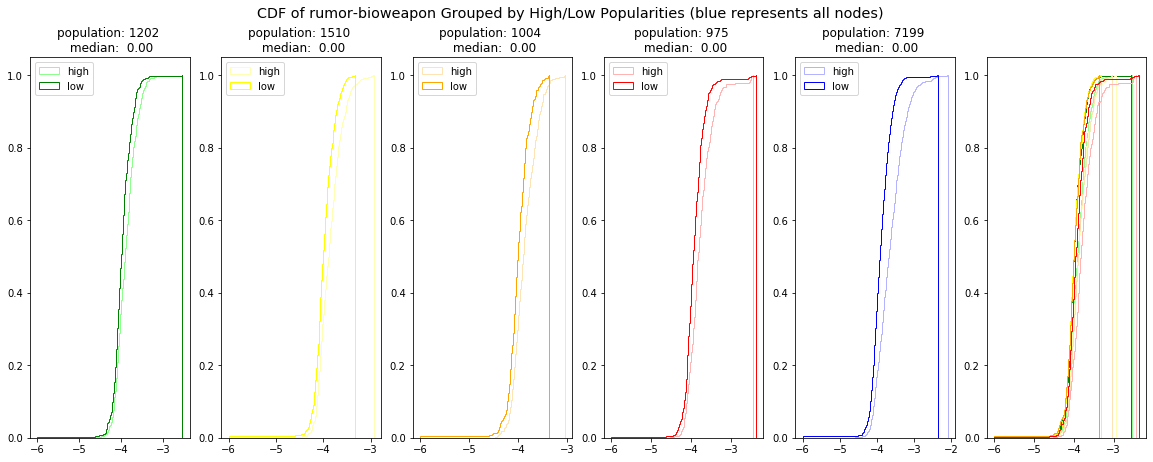

In [12]:
#rumor-bio -> pop



plot_df = all_nodes_df
cumulative = True
scale = np.log10

fig, ax = plt.subplots(1, 6, figsize=(20, 7))

fig.suptitle("CDF of rumor-bioweapon Grouped by High/Low Popularities (blue represents all nodes)", fontsize="x-large")

for i, color in enumerate(non_mix_COLORS):
    _color_data = plot_df[(plot_df['color'] == COLORS.index(color))]
    
    _pop = _color_data['pop']
    
    _high_data = _color_data[_color_data['pop'] >= np.median(_pop)]
    _low_data = _color_data[_color_data['pop'] < np.median(_pop)]
    
    ax[i].hist(scale(_high_data['rumor_bioweapon'] + 1e-6), color=lighten_color(color, 0.3), density=True, bins=400, cumulative=cumulative, histtype='step', label='high')
    ax[i].hist(scale(_low_data['rumor_bioweapon'] + 1e-6), color=lighten_color(color, 1.0), density=True, bins=400, cumulative=cumulative, histtype='step', label='low')
    
    
    ax[i].set_title(f'population: {len(_color_data)} \n median: {np.median(_pop): .2f}')
    
    ax[i].legend(loc='upper left')
    
    ax[5].hist(scale(_high_data['rumor_bioweapon'] + 1e-6), color=lighten_color(color, 0.3), density=True, bins=400, cumulative=cumulative, histtype='step', label='high')
    ax[5].hist(scale(_low_data['rumor_bioweapon'] + 1e-6), color=lighten_color(color, 1.0), density=True, bins=400, cumulative=cumulative, histtype='step', label='low')
    
    

_pop = plot_df['pop']
_high_data = plot_df[plot_df['pop'] >= np.median(_pop)]
_low_data = plot_df[plot_df['pop'] < np.median(_pop)]


ax[4].hist(scale(_high_data['rumor_bioweapon'] + 1e-6), color=lighten_color('blue', 0.3), density=True, bins=400, cumulative=True, histtype='step', label='high')
ax[4].hist(scale(_low_data['rumor_bioweapon'] + 1e-6), color=lighten_color('blue', 1.0), density=True, bins=400, cumulative=True, histtype='step', label='low')

ax[4].set_title(f'population: {len(plot_df)} \n median: {np.median(_pop): .2f}')
ax[4].legend(loc='upper left')


plt.show()

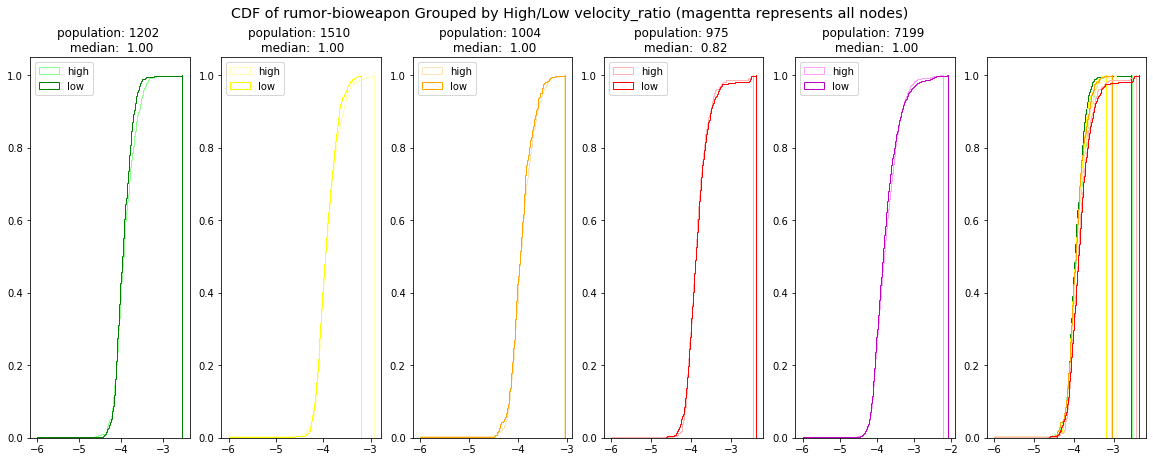

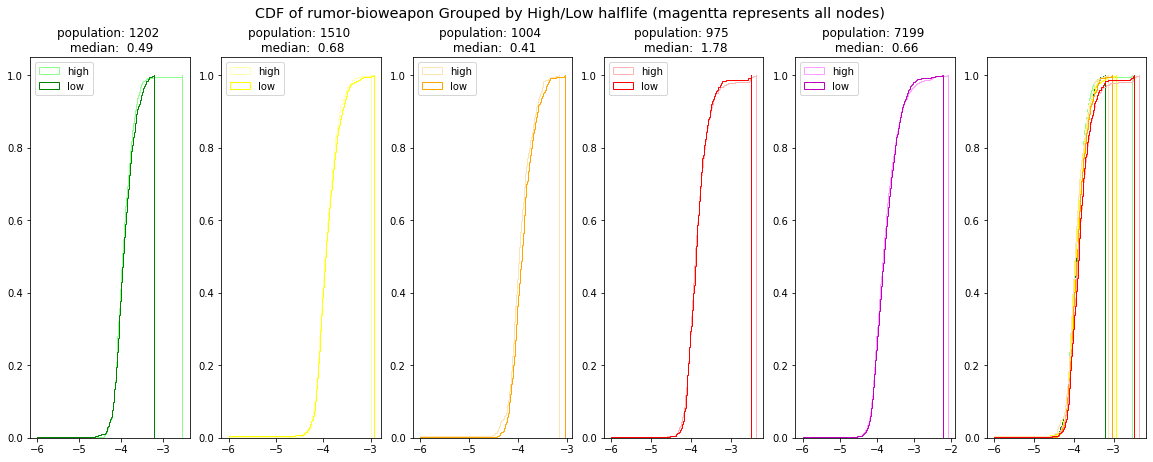

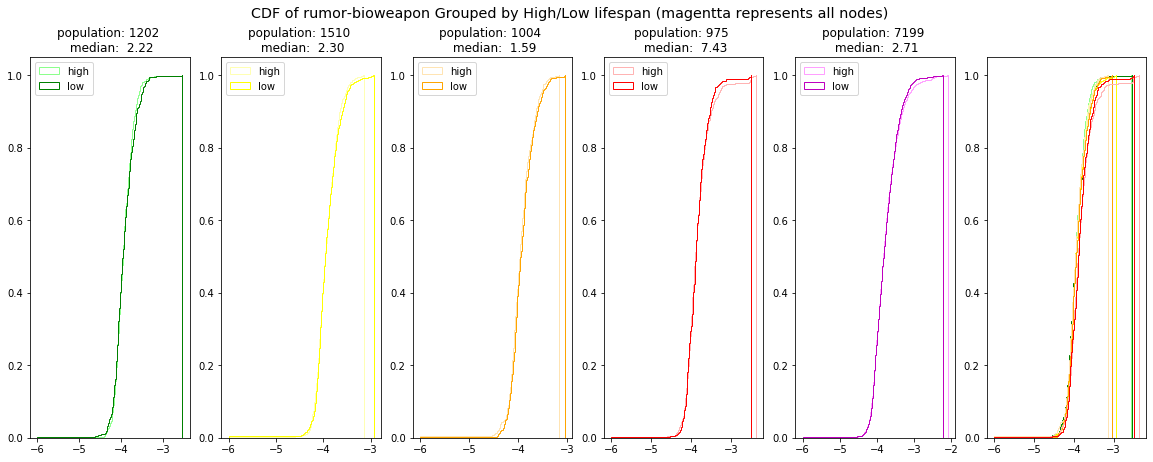

In [13]:
#homophily -> velocity

plot_df = all_nodes_df

cumulative = True

scale = np.log10
# scale = np.log10

for velocity in ['velocity_ratio', 'halflife', 'lifespan']:
    fig, ax = plt.subplots(1, 6, figsize=(20, 7))

    fig.suptitle(f"CDF of rumor-bioweapon Grouped by High/Low {velocity} (magentta represents all nodes)", fontsize="x-large")

    for i, color in enumerate(non_mix_COLORS):
        _color_data = plot_df[(plot_df['color'] == COLORS.index(color))]

        _pop = _color_data[velocity]

        _high_data = _color_data[_color_data[velocity] >= np.median(_pop)]
        _low_data = _color_data[_color_data[velocity] < np.median(_pop)]

        ax[i].hist(scale(_high_data['rumor_bioweapon'] + 1e-6), color=lighten_color(color, 0.3), density=True, bins=400, cumulative=cumulative, histtype='step', label='high')
        ax[i].hist(scale(_low_data['rumor_bioweapon'] + 1e-6), color=lighten_color(color, 1.0), density=True, bins=400, cumulative=cumulative, histtype='step', label='low')

        ax[i].legend(loc='upper left')

        ax[i].set_title(f'population: {len(_color_data)} \n median: {np.median(_pop): .2f}')


        ax[5].hist(scale(_high_data['rumor_bioweapon'] + 1e-6), color=lighten_color(color, 0.3), density=True, bins=400, cumulative=cumulative, histtype='step', label='high')
        ax[5].hist(scale(_low_data['rumor_bioweapon'] + 1e-6), color=lighten_color(color, 1.0), density=True, bins=400, cumulative=cumulative, histtype='step', label='low')


    _pop = plot_df[velocity]
    _high_data = plot_df[plot_df[velocity] >= np.median(_pop)]
    _low_data = plot_df[plot_df[velocity] < np.median(_pop)]

    ax[4].hist(scale(_high_data['rumor_bioweapon'] + 1e-6), color=lighten_color('m', 0.3), density=True, bins=400, cumulative=True, histtype='step', label='high')
    ax[4].hist(scale(_low_data['rumor_bioweapon'] + 1e-6), color=lighten_color('m', 1.0), density=True, bins=400, cumulative=True, histtype='step', label='low')

    ax[4].set_title(f'population: {len(plot_df)} \n median: {np.median(_pop): .2f}')
    ax[4].legend(loc='upper left')


    plt.show()


### Highlighted Observations:



1. rumor-relatedness is different for different popularity nodes. High pop nodes tends to have higher relatedness to the rumor "bioweapon"
2. among all data series, "red + high-pop" has the highest relatedness to the rumor "bioweapon"
3. the rumor-relatedness is not sensitive to the high/low propagation velocity.
4. overall red nodes has higher relatedness to rumor "bioweapon"

# What features are informative predicting the node colors?

After summarizing the distribution of features, I want to see the predictive power of those features to color/popularity/velocity ratio. I use a logistic regression to see the linear significance of the feature predictive power.

Before feeding all nodes into the model, I first filter out some "duplicated" nodes (nodes that appear mostly in the same articles, so that they inharitate similar features and labels which will overwhelm the model).

I calculate the proportion of the #duplicated articles/#all articles for each node pair, and arbitrarily set a threshold 0.5 to determine the node pairs are duplicated or not. Once a node pair is determined as duplicate, I remove the less appeared node (regarding all duplicated nodes) from the pair. (e.g. A appeared in 3 pairs and B appeared in 1 pair, when the pair is A and B the node B is filtered out).

This removal of duplication will make the sample size from ~4,600 (nodes with dominant color codings) to ~4,200.

In [14]:
#get posts of nodes
G, GD, nodes_in_graph, und_edges_in_graph, dir_edges_in_graph = pickle.load(open(f'output/graph_title+1s_all_nodes_merged.pkl', 'rb'))
# ALL_RELS, ALL_RAW = pickle.load(open('data/title+1s_all_merged.pkl', 'rb'))


node_posts = {}
for edge in und_edges_in_graph:
    
    verb = und_edges_in_graph[edge]
    for v in verb:
        _posts = v['posts']
        _node0 = edge.split('<->')[0]
        _node1 = edge.split('<->')[1]
        
        if _node0 in G:
            if _node0 not in node_posts:
                node_posts[_node0] = set([])
            node_posts[_node0].update(_posts)
            
        if _node1 in G:
            if _node1 not in node_posts:
                node_posts[_node1] = set([])
            node_posts[_node1].update(_posts)
            
all_nodes = list(node_posts.keys())

overwrite = False

if not overwrite and os.path.exists('data/cache/dup_pairs_all.pkl'):
    
    dup_pairs = pickle.load(open('data/cache/dup_pairs_all.pkl', 'rb'))
else:
    dup_pairs = []
    for i in tqdm(range(len(all_nodes))):
        for j in range(i+1, len(all_nodes)):
            _sim = len(node_posts[all_nodes[i]] & node_posts[all_nodes[j]]) / len(node_posts[all_nodes[i]] | node_posts[all_nodes[j]])
            if _sim >= 0.5:
                dup_pairs.append((i, j))
    pickle.dump(dup_pairs, open('data/cache/dup_pairs_all.pkl', 'wb'))
    
    
dup_count = {}
for pair in dup_pairs:
    node0 = all_nodes[pair[0]]
    node1 = all_nodes[pair[1]]
    
    if node0 not in dup_count:
        dup_count[node0] = 0
    if node1 not in dup_count:
        dup_count[node1] = 0
    dup_count[node0] += 1
    dup_count[node1] += 1
    
node2exclude = set([])
for pair in dup_pairs:
    node0 = all_nodes[pair[0]]
    node1 = all_nodes[pair[1]]
    
    if dup_count[node0] > dup_count[node1]:
        node2exclude.add(node1)
    else:
        node2exclude.add(node0)

In [15]:
all_nodes_df.head()

,name,week,color,self_green,self_yellow,self_orange,self_red,connect_green,connect_yellow,connect_orange,...,we,work,you,pop,rt,fav,lifespan,halflife,velocity_ratio,rumor_bioweapon
0,SUPER:people_wearing_face|one_man|man,NA,4,0.256972,0.587649,0.072709,0.082669,0.070421,0.126454,0.072399,...,0.034483,0.398220,0.018910,0.009831,5.562749,13.951195,6.811250,1.042083,0.984453,0.002450
2,SUPER:oak_medical_centre|centre|central_bank,NA,4,0.308333,0.350000,0.291667,0.050000,0.029662,0.056303,0.129851,...,0.037736,0.603774,0.006289,0.006970,10.383333,23.275000,3.369028,0.813333,0.779567,0.000691
3,SUPER:heathrow_airport|heathrow,NA,1,0.222222,0.703704,0.037037,0.037037,0.055167,0.078537,0.000000,...,0.000000,0.333333,0.000000,0.001838,1.222222,1.518519,8.624444,1.431389,0.910424,0.000374
4,SUPER:uk_government|chinese_government|government,NA,4,0.387290,0.369305,0.154676,0.088729,0.088680,0.046590,0.110917,...,0.080106,0.998239,0.016725,0.003550,6.721823,13.488010,4.782083,1.054722,0.970077,0.004524
5,SUPER:health_risk|risk|high_risk,NA,4,0.290984,0.532787,0.106557,0.069672,0.049184,0.039385,0.053828,...,0.076923,0.513986,0.038462,0.005654,4.360656,8.856557,2.531111,0.485139,1.000000,0.000993


In [16]:
#prepare x 
ins_df = all_nodes_df

quantile_transformer = preprocessing.QuantileTransformer(n_quantiles=10000, output_distribution='normal', random_state=42)
minmax = preprocessing.MinMaxScaler()


#transform non-probability features (e.g. LIWC features) into normal distribution by quantiles. 
#This spreads the over centralized values (e.g. in popularity) and provide robustness against extreme outliers

# norm_data = minmax.fit_transform(quantile_transformer.fit_transform(ins_df[ins_df.columns[13:]])) #[13:] non-probability features





normalized_df = copy.deepcopy(ins_df)
normalized_df = normalized_df[normalized_df['color'] <= 3] #excluding mixed nodes
norm_data = minmax.fit_transform(normalized_df[normalized_df.columns[12:84]]) #[13:] non-probability features
normalized_df[normalized_df.columns[12:84]] = norm_data

_scores = np.array(normalized_df['rumor_bioweapon'])
_scores = (_scores - np.min(_scores)) / (np.max(_scores) - np.min(_scores))
normalized_df['rumor_bioweapon'] = _scores




normalized_df = normalized_df[~normalized_df['name'].isin(node2exclude)]

x = normalized_df[['connect_green', 'connect_yellow', 'connect_orange', 'connect_red', 'homophily', 
                   'freq', 'anger', 'anx', 'certain', 'death', 
                   'family', 'health', 'negate', 'posemo', 
                   'relig', 'sad', 'social',  'swear', 'rumor_bioweapon']]


print(x.shape)

(4247, 19)


In [17]:
#predict color orange/red as 1, yellow/green as 0
y_color = normalized_df['color']
y_bin = [1 if item >= 2 else 0 for item in y_color]



sm_model = sm.Logit(y_bin, x).fit_regularized(method='l1')

sm_model.summary()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6061509667609305
            Iterations: 154
            Function evaluations: 154
            Gradient evaluations: 154


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 4247
Model:                          Logit   Df Residuals:                     4228
Method:                           MLE   Df Model:                           18
Date:                Mon, 31 Aug 2020   Pseudo R-squ.:                  0.1130
Time:                        15:32:15   Log-Likelihood:                -2574.3
converged:                       True   LL-Null:                       -2902.3
Covariance Type:            nonrobust   LLR p-value:                1.288e-127
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
connect_green      -4.4010      0.359    -12.252      0.000      -5.105      -3.697
connect_yellow     -4.3001      0.344    -12.505      0.000      -4.974      -3.626
connect_orange      0.9697      0.264      3.674      0.000       0.452       1.487
connect_red         0.7991      0.231      3.453      0.001       0.346       1.253
homophily           2.7851      0.269     10.348      0.000       2.258       3.313
freq                3.5395      1.942      1.823      0.068      -0.266       7.345
anger               0.1327      0.139      0.954      0.340      -0.140       0.405
anx                -0.5263      0.168     -3.141      0.002      -0.855      -0.198
certain             0.4108      0.156      2.632      0.008       0.105       0.717
death              -0.2328      0.154     -1.507      0.132      -0.536       0.070
family             -0.3350      0.206     -1.625      0.104      -0.739       0.069
health             -0.0663      0.115     -0.578      0.563      -0.291       0.159
negate              0.0035      0.176      0.020      0.984      -0.342       0.349
posemo             -0.2904      0.112     -2.602      0.009      -0.509      -0.072
relig               0.6894      0.166      4.159      0.000       0.365       1.014
sad                -0.5171      0.193     -2.681      0.007      -0.895      -0.139
social             -0.3245      0.092     -3.523      0.000      -0.505      -0.144
swear              -0.5007      0.729     -0.686      0.492      -1.930       0.929
rumor_bioweapon     1.8523      0.896      2.068      0.039       0.097       3.608
===================================================================================
"""

From the results, when taking suspicious (color is orange/red) as positive labels:

- suspicious nodes tends to connect to suspicisous node
- suspicious nodes tends to have higher homophily (connect to only same type nodes)
- in LIWC features, suspicious nodes have less **anxiety, positive emotion, sadness, and social**, but more **certainty and religion**
- rumor-bioweapon is also positively significant when predicting the suspiciousness

In [18]:
y_prop = normalized_df['pop']
y_bin = [1 if item >= np.median(y_prop) else 0 for item in y_prop]


sm_model = sm.Logit(y_bin, x).fit_regularized(method='l1')
sm_model.summary()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6370105280114582
            Iterations: 150
            Function evaluations: 151
            Gradient evaluations: 150


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 4247
Model:                          Logit   Df Residuals:                     4228
Method:                           MLE   Df Model:                           18
Date:                Mon, 31 Aug 2020   Pseudo R-squ.:                 0.08099
Time:                        15:32:16   Log-Likelihood:                -2705.4
converged:                       True   LL-Null:                       -2943.8
Covariance Type:            nonrobust   LLR p-value:                 7.704e-90
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
connect_green      -0.0295      0.272     -0.108      0.914      -0.563       0.504
connect_yellow      0.0528      0.271      0.195      0.845      -0.478       0.583
connect_orange     -0.9060      0.247     -3.666      0.000      -1.390      -0.422
connect_red        -0.1383      0.217     -0.637      0.524      -0.564       0.287
homophily          -0.3587      0.217     -1.650      0.099      -0.785       0.067
freq              111.6190      7.494     14.894      0.000      96.931     126.307
anger               0.0644      0.130      0.495      0.620      -0.190       0.319
anx                -0.0706      0.155     -0.457      0.648      -0.374       0.232
certain            -0.2742      0.150     -1.826      0.068      -0.568       0.020
death              -0.1255      0.146     -0.862      0.389      -0.411       0.160
family             -0.0254      0.185     -0.137      0.891      -0.389       0.338
health             -0.1117      0.108     -1.031      0.302      -0.324       0.101
negate             -0.0715      0.166     -0.431      0.667      -0.397       0.254
posemo             -0.2076      0.105     -1.981      0.048      -0.413      -0.002
relig              -0.2133      0.158     -1.354      0.176      -0.522       0.096
sad                 0.1179      0.176      0.670      0.503      -0.227       0.463
social             -0.1821      0.088     -2.074      0.038      -0.354      -0.010
swear               0.4385      0.679      0.646      0.518      -0.892       1.769
rumor_bioweapon    -2.7073      0.892     -3.035      0.002      -4.455      -0.959
===================================================================================
"""

Predicting popularity (popular as 1, unpop as 0):

- connecting to orange nodes is an indicator of "not popular"
- *freq* is #actants appearance per node, it is not normalized so I cannot draw an conclusion on it
- among all LIWC features, having **positive emotion and social** will make the nodes less popular
- relatedness to the rumor of bioweapon contribut negatively predicting popularity.

In [19]:

y_prop = normalized_df['halflife']
y_bin = [1 if item >= np.median(y_prop) else 0 for item in y_prop]

print(np.median(y_prop))

sm_model = sm.Logit(y_bin, x).fit_regularized(method='l1')

sm_model.summary()

0.74125
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6774768051220627
            Iterations: 145
            Function evaluations: 145
            Gradient evaluations: 145


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 4247
Model:                          Logit   Df Residuals:                     4228
Method:                           MLE   Df Model:                           18
Date:                Mon, 31 Aug 2020   Pseudo R-squ.:                 0.02261
Time:                        15:32:16   Log-Likelihood:                -2877.2
converged:                       True   LL-Null:                       -2943.8
Covariance Type:            nonrobust   LLR p-value:                 1.353e-19
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
connect_green      -1.0033      0.271     -3.699      0.000      -1.535      -0.472
connect_yellow     -0.8867      0.269     -3.295      0.001      -1.414      -0.359
connect_orange     -0.9221      0.239     -3.866      0.000      -1.390      -0.455
connect_red         0.6117      0.217      2.823      0.005       0.187       1.036
homophily           0.0984      0.215      0.458      0.647      -0.323       0.520
freq               -5.7066      2.175     -2.624      0.009      -9.969      -1.444
anger               0.3969      0.129      3.071      0.002       0.144       0.650
anx                -0.0796      0.152     -0.524      0.600      -0.377       0.218
certain             0.0981      0.146      0.671      0.502      -0.188       0.385
death               0.4528      0.144      3.136      0.002       0.170       0.736
family             -0.7401      0.185     -4.002      0.000      -1.103      -0.378
health              0.1896      0.106      1.784      0.074      -0.019       0.398
negate              0.1567      0.163      0.964      0.335      -0.162       0.475
posemo             -0.2983      0.103     -2.894      0.004      -0.500      -0.096
relig              -0.1157      0.153     -0.756      0.450      -0.416       0.184
sad                 0.0149      0.175      0.085      0.932      -0.327       0.357
social              0.1705      0.086      1.990      0.047       0.003       0.338
swear              -1.2058      0.710     -1.699      0.089      -2.597       0.185
rumor_bioweapon     0.2142      0.686      0.312      0.755      -1.130       1.559
===================================================================================
"""

Predicting propagation velocity (half-life, median = 0.74 hrs):

- connect to green/yellow/orange contribute negatively to low-velocity (long halflife), connect to red contribute positively
- **anger, family, positive emotion** contribute nagatively (when having, propagate faster)
- **death, social** contribute positively (when having, propagate slower)


In [20]:

y_prop = normalized_df['velocity_ratio']
y_bin = [1 if item >= np.median(y_prop) else 0 for item in y_prop]

print(np.median(y_prop))

sm_model = sm.Logit(y_bin, x).fit_regularized(method='l1')

sm_model.summary()

0.9988552504073179
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6824123750646398
            Iterations: 141
            Function evaluations: 141
            Gradient evaluations: 141


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 4247
Model:                          Logit   Df Residuals:                     4228
Method:                           MLE   Df Model:                           18
Date:                Mon, 31 Aug 2020   Pseudo R-squ.:                 0.01549
Time:                        15:32:17   Log-Likelihood:                -2898.2
converged:                       True   LL-Null:                       -2943.8
Covariance Type:            nonrobust   LLR p-value:                 8.856e-12
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
connect_green       0.5732      0.268      2.142      0.032       0.049       1.098
connect_yellow      0.8096      0.267      3.028      0.002       0.286       1.334
connect_orange      0.6334      0.236      2.686      0.007       0.171       1.096
connect_red        -0.4074      0.214     -1.906      0.057      -0.826       0.012
homophily          -0.0430      0.212     -0.202      0.840      -0.459       0.373
freq                5.9772      2.197      2.720      0.007       1.670      10.284
anger              -0.3456      0.128     -2.696      0.007      -0.597      -0.094
anx                 0.0249      0.151      0.165      0.869      -0.271       0.321
certain            -0.1154      0.145     -0.794      0.427      -0.400       0.169
death              -0.2202      0.143     -1.545      0.122      -0.500       0.059
family              0.5631      0.183      3.077      0.002       0.204       0.922
health             -0.2791      0.106     -2.639      0.008      -0.486      -0.072
negate             -0.3285      0.162     -2.025      0.043      -0.647      -0.011
posemo              0.2323      0.102      2.266      0.023       0.031       0.433
relig              -0.1016      0.152     -0.668      0.504      -0.400       0.197
sad                 0.2160      0.174      1.243      0.214      -0.125       0.557
social             -0.0252      0.085     -0.296      0.767      -0.192       0.142
swear               1.3776      0.721      1.910      0.056      -0.036       2.791
rumor_bioweapon    -0.8049      0.710     -1.133      0.257      -2.197       0.587
===================================================================================
"""

Predicting propagation velocity (ratio, median 0.99):

Many nodes are from articles getting 1 share (where ratio=1 since the last post is the middle post).

- connect to green/yellow/orange would make the propagation slower, connect to red would make it faster
- **anger, health, negate** would make the propagation faster
- **family, positive emotion** would make the propagation slower